# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [4]:
dataset = pd.read_csv('indie_onehot.csv')
#sample from dataset for ease of use
#  dataset = dataset.sample(frac=0.1, random_state=0)
dataset['Indie'] = dataset['Indie'].astype(int)
dataset['reviews'] = dataset['reviews'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
#only need the review and the classification for now
train_dataset = train_dataset[['reviews', 'Indie']]
test_dataset = test_dataset[['reviews', 'Indie']]
train_dataset.head()

(7248, 8)
Index(['Unnamed: 0', 'AppID', 'reviews', 'Genres', 'Tags', 'Price',
       'Estimated.owners', 'Indie'],
      dtype='object')


,reviews,Indie
1513,"Very good metroidvania, but I gotta mention, t...",1
6255,this game was very fun at first but im just up...,0
2577,"Great game, the whole family played during tha...",1
4968,This is indie black and white. It is pretty e...,1
5114,The game is too disturbing. I have never felt ...,1


In [5]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
#tf_train_dataset = tf.convert_to_tensor(train_dataset)
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
tf_train_dataset.element_spec

{'reviews': TensorSpec(shape=(), dtype=tf.string, name=None),
 'Indie': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [6]:
for elem in tf_train_dataset.take(1):
  print('Reviews: ', elem['reviews'].numpy())
  print('Indie: ', elem['Indie'].numpy())

Reviews:  b'Very good metroidvania, but I gotta mention, the platforming is hard.\r\nFully recommend.|;|Haak is a little better than I was expecting. I think I was primed for a more average experience having played some middling mv\'s before this one. It\'s great! I think I maybe just agree with the general sentiment, and maybe I also agree that it\'s a bit overrated, but all in all? Way better than most, offers more secrets and exploration than you\'d probably expect and a few welcome twists to the familiar formula. This is well worth your time, and I say that as an avid mv fan. 8.45/10|;|RECOMMENDED, a truly brilliant game. Responsive, smooth (X-Box) controls and interesting gameplay. Normally I do not replay games but since I had no MV\'s on my wish list I decided to buy HAAK again. I had already played it on Switch, some years ago already but it was fresh enough. An old woman\'s terrible memory helps with that \xf0\x9f\x98\x81. Thoroughly enjoyed my second playthrough as well.|;|\x

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for element in tf_train_dataset.take(1):
  print('texts: ', element['reviews'].numpy()[:3])
  print()
  print('labels: ', element['Indie'].numpy()[:3])

texts:  [b'Oscar & Gems: Puzzle Quest a fun and simple match-3 puzzle game with fun elements, game\r\nwithout built-in payments...\r\n8/10|;|Going to do this review thing on this game, because because there are too few reviews.\r\nThe game is good with a fun style and interesting gameplay.|;|Very fun way to kill time. Lots of Fun.'
 b'really, really enjoyed the premise and it\'s very im-simmy, but it\'s buggy (e.g the in-game cli bugged out on me if i tried to up-arrow previous cmds and it stopped working even after a restart)|;|good|;|A very fun heist game using the command line on you laptop to use tools.\r\nunfortunately it\'s really quite short and never feels like it \'gets going\' in regards to difficulty.\r\nadditionally there were two tabs in the guide book which were scribbled out, which felt like they were going to be tools for later but they never showed up.\r\n8/10 wish there was more levels and maybe more substance to go with it|;|Not a super long game.\r\nIt has a heartwa

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train_dataset.map(lambda x: x['reviews']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'of', 'i', 'is',
       'it', 'you', 'this', 'in', 'that', 'for', 'but', 'with', 'on',
       'are'], dtype='<U31')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(element['reviews'])[:3].numpy()
encoded_example

array([[   1, 2437,  219, ...,    0,    0,    0],
       [  46,   46,  299, ...,    0,    0,    0],
       [ 463,    2,   73, ...,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [14]:
for n in range(3):
  print("Original: ", element['reviews'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Oscar & Gems: Puzzle Quest a fun and simple match-3 puzzle game with fun elements, game\r\nwithout built-in payments...\r\n8/10|;|Going to do this review thing on this game, because because there are too few reviews.\r\nThe game is good with a fun style and interesting gameplay.|;|Very fun way to kill time. Lots of Fun.'
Round-trip:  [UNK] gems puzzle quest a fun and simple match3 puzzle game with fun elements game without builtin [UNK] [UNK] to do this review thing on this game because because there are too few reviews the game is good with a fun style and interesting [UNK] fun way to kill time lots of fun                                                                                                                                                                                                                                                                                                                                                                                     

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #changed from 64
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [41]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [32]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
[-0.01233131]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [33]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[-0.01233131]


## Train the model

In [42]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['reviews']), x['Indie']))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['reviews']), x['Indie']))

history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 800ms/step - accuracy: 0.4319 - loss: 0.6726 - val_accuracy: 0.6073 - val_loss: 0.6607
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 92s 808ms/step - accuracy: 0.5919 - loss: 0.6495 - val_accuracy: 0.6453 - val_loss: 0.6526
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 90s 788ms/step - accuracy: 0.6217 - loss: 0.6453 - val_accuracy: 0.7984 - val_loss: 0.4903
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 828ms/step - accuracy: 0.7546 - loss: 0.4872 - val_accuracy: 0.8292 - val_loss: 0.3888
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 89s 783ms/step - accuracy: 0.8151 - loss: 0.3956 - val_accuracy: 0.8677 - val_loss: 0.3539
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 90s 785ms/step - accuracy: 0.8419 - loss: 0.3535 - val_accuracy: 0.8682 - val_loss: 0.2906
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 91s 796ms/step - accuracy: 0.8882 - loss: 0.2750 - val_accuracy: 0.9234 - val_loss: 0.1998
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 811ms/step - accuracy: 0.9220 - loss: 0

In [43]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

114/114 ━━━━━━━━━━━━━━━━━━━━ 37s 330ms/step - accuracy: 0.9665 - loss: 0.0825
Test Loss: 0.08483242988586426
Test Accuracy: 0.9670253992080688


(0.0, 0.6981130879372358)

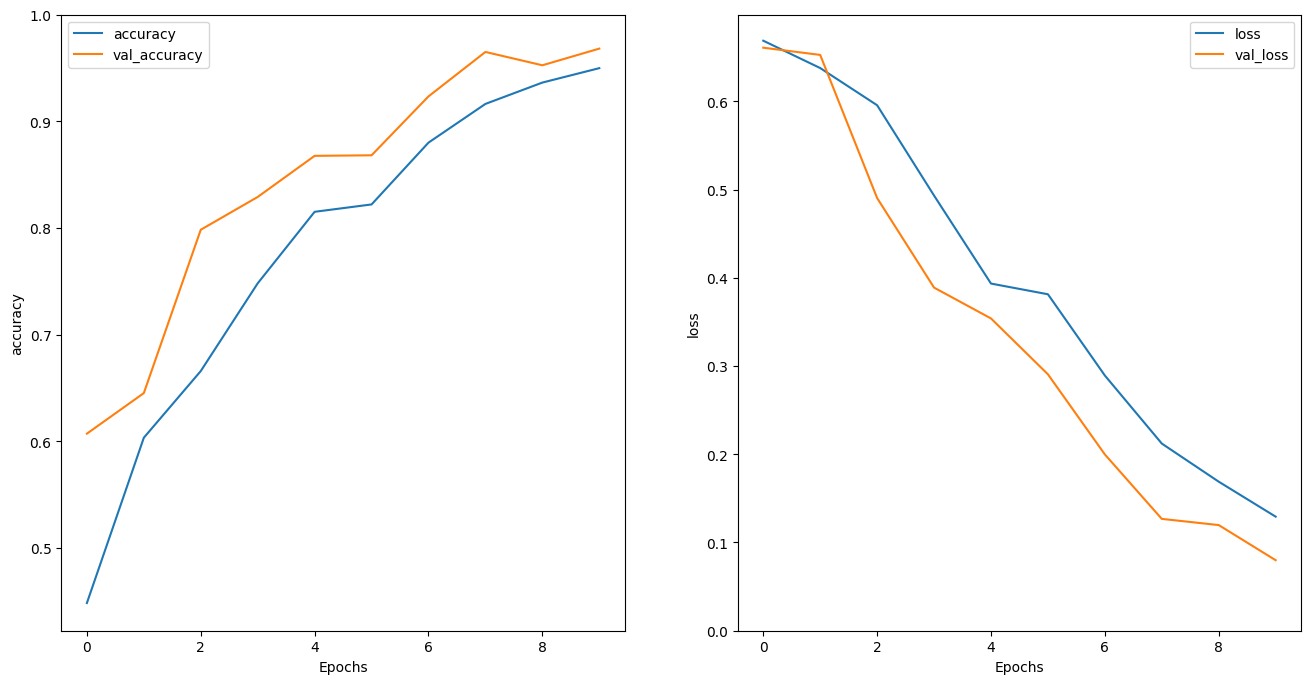

In [44]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [49]:
sample_text = ('This indie game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was not cool. The animation and the graphics '
               'were basic, cheap. I would not recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[1.5916795]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[0.74824977]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[3.3958144]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [1]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, use_cudnn=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

NameError: name 'tf' is not defined

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.5764 - loss: 0.5984 - val_accuracy: 0.8188 - val_loss: 0.4095
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8313 - loss: 0.3805 - val_accuracy: 0.8630 - val_loss: 0.2952
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.8739 - loss: 0.3038 - val_accuracy: 0.9104 - val_loss: 0.2654
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8984 - loss: 0.2607 - val_accuracy: 0.9234 - val_loss: 0.2080
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9133 - loss: 0.2291 - val_accuracy: 0.9089 - val_loss: 0.2612
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9064 - loss: 0.2487 - val_accuracy: 0.9245 - val_loss: 0.1864
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.9272 - loss: 0.1961 - val_accuracy: 0.9427 - val_loss: 0.1662
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9351 - loss: 0.1858 -

In [ ]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

460/460 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9471 - loss: 0.1625
Test Loss: 0.16997113823890686
Test Accuracy: 0.9440195560455322


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[[-2.170004]]


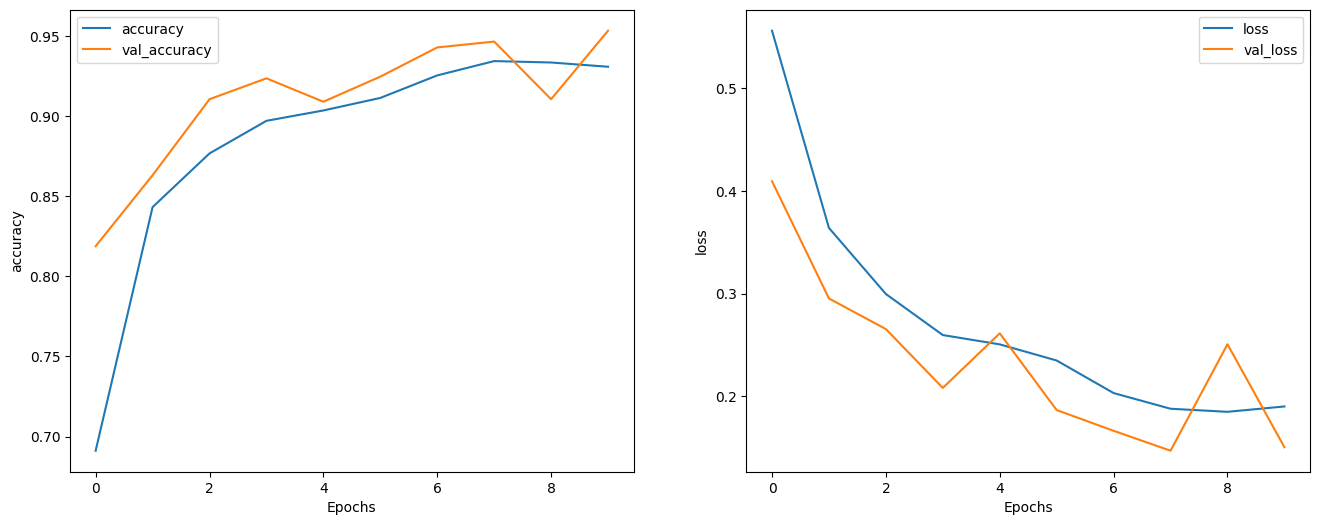

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
